# Training the model on images

## Imports

In [1]:
# load custom scripts
from dataset import Dataset
from utils import *
import config 

# import the necessary packages
from albumentations.pytorch import ToTensorV2
from imutils import paths
from skimage import io
from sklearn.model_selection import train_test_split
from torch import optim
from torch.nn import CrossEntropyLoss 
from torch.optim import Adam
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from tqdm import tqdm
from utils import EarlyStopping
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random
import segmentation_models_pytorch as smp
import time
import torch
import torchmetrics
import os

## Controlling sources of randomness

In [2]:
# Set seed
SEED = 42
seed_all(SEED)

## Setup CUDA

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"[INFO] CUDA version: {torch.version.cuda}")
  
# storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"[INFO] ID of current CUDA device:{torch.cuda.current_device()}")
        
print(f"[INFO] Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
[INFO] CUDA version: 11.1
[INFO] ID of current CUDA device:0
[INFO] Name of current CUDA device:NVIDIA GeForce RTX 3090


## Load images

In [4]:
# load the image and label filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
labelPaths = sorted(list(paths.list_images("/data/jantina/CoralNet/dataset/labels_dense")))

trainImages, testImages, trainLabels, testLabels = train_test_split(imagePaths,
                                                                    labelPaths,
                                                                    test_size=0.2,
                                                                    train_size=0.8,
                                                                    random_state=SEED)
testImages, valImages, testLabels, valLabels = train_test_split(testImages, 
                                                                  testLabels,
                                                                  test_size=0.5,
                                                                  train_size=0.5,
                                                                  random_state=SEED)

# get the masks corresponding to the labels
trainMasks = [s.replace('labels_dense', 'masks_9x9') for s in trainLabels]
valMasks = [s.replace('labels_dense', 'masks_9x9') for s in valLabels]

# save testing images to disk
print("[INFO] saving testing image paths...")
f = open("/data/jantina/CoralNet/dataset/output_dense/test_paths.txt", "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


## Example

In [5]:
# new label classes
classes = {1: 'hard coral',
           2: 'hard coral bleached',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: 'algae',
           8: 'seagrass',
           9: 'unknown',
           0: 'no label'
          }

In [6]:
a=random.randrange(len(trainImages))
image = io.imread(trainImages[a])
label = io.imread(trainLabels[a])
mask = io.imread(trainMasks[a])

print(f"Image name: {trainImages[a].split('/')[-1]}")
print(f"Image dtype: {image.dtype}, Label dtype: {label.dtype}")

Image name: (1153).JPG
Image dtype: uint8, Label dtype: uint8


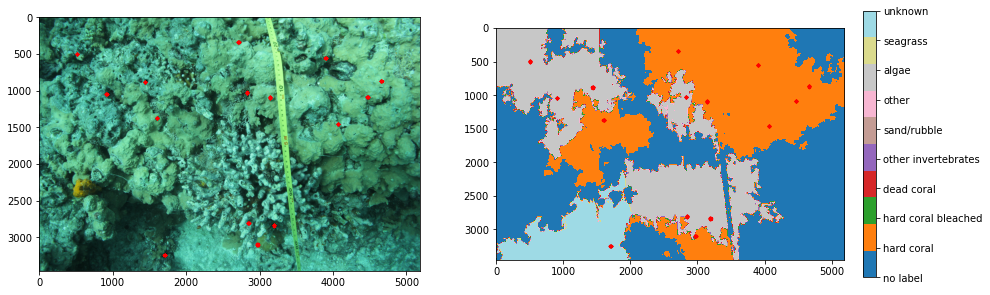

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 15))
ax[0].imshow(image)
ax[0].scatter(np.nonzero(mask)[1], np.nonzero(mask)[0], s=20, marker='.', c='r')

cax = ax[1].imshow(label, cmap = plt.cm.get_cmap('tab20', 10), vmin=0, vmax=9)
ax[1].scatter(np.nonzero(mask)[1], np.nonzero(mask)[0], s=20, marker='.', c='r')

cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035, pad=0.05)
cbar.ax.set_yticklabels(list(classes.values()))
plt.show()

## Transforms

In [8]:
train_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=cv2.INTER_NEAREST),    
    A.HorizontalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()],
    additional_targets={'mask2': 'mask'}
)

In [9]:
val_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=cv2.INTER_NEAREST),    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()],
    additional_targets={'mask2': 'mask'}
)

In [10]:
image = io.imread(trainImages[a])
label = io.imread(trainLabels[a])
mask = io.imread(trainMasks[a])
transformed = train_transform(image=image, mask=label, mask2=mask)
image = transformed["image"]
label = transformed["mask"]
mask = transformed["mask2"]
            
# convert label and mask to long tensor
label = label.type(torch.LongTensor)
mask = mask.type(torch.LongTensor)

/tmp/ipykernel_1969242/1473477371.py:10: MatplotlibDeprecationWarning:

Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().



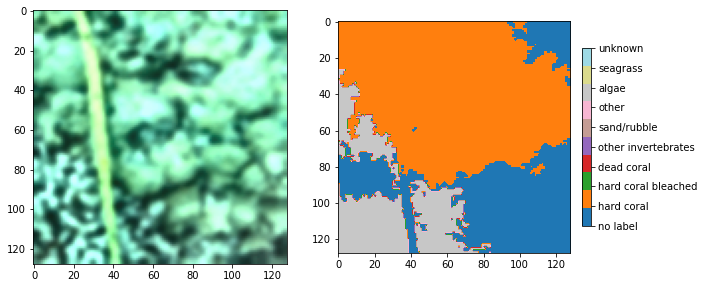

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 10))
ax[0].imshow(unnormalize(image).permute(1, 2, 0))
ax[0].scatter(np.nonzero(mask)[:,1], np.nonzero(mask)[:,0], s=20, marker='.', c='r')

ax[1].imshow(label,
             cmap = plt.cm.get_cmap('tab20', 10), 
             vmin=0, vmax=9)
ax[1].scatter(np.nonzero(mask)[:,1], np.nonzero(mask)[:,0], s=20, marker='.', c='r')

cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035)
cbar.ax.set_yticklabels(list(classes.values()))
plt.show()

## Create dataset

In [12]:
# create the train and validation datasets
startTime = time.time()
trainDS = Dataset(imagePaths=trainImages, labelPaths = trainLabels, maskPaths=trainMasks, transform=train_transform)
valDS = Dataset(imagePaths=valImages, labelPaths = valLabels, maskPaths=valMasks, transform=val_transform)
print(f"[INFO] found {len(trainDS)} examples in the training set")
print(f"[INFO] found {len(valDS)} examples in the validation set")
print(f"[INFO] found {len(testImages)} examples in the test set")
endTime = time.time()
print("[INFO] total time taken to load the data: {:.2f}s".format(endTime - startTime))

[INFO] found 6829 examples in the training set
[INFO] found 854 examples in the validation set
[INFO] found 854 examples in the test set
[INFO] total time taken to load the data: 0.00s


In [13]:
sample = valDS[0]
print(f"Feature shape: {sample[0].shape}, Feature type: {sample[0].dtype}")
print(f"Label shape: {sample[1].shape}, Label type: {sample[1].dtype}")
print(f"Mask shape: {sample[2].shape}, Mask type: {sample[2].dtype}")

Feature shape: torch.Size([3, 128, 128]), Feature type: torch.float32
Label shape: torch.Size([128, 128]), Label type: torch.int64
Mask shape: torch.Size([128, 128]), Mask type: torch.int64


In [14]:
# create the training and validation data loaders
trainLoader = DataLoader(trainDS, shuffle=True, 
                         batch_size=config.BATCH_SIZE, 
                         pin_memory=config.PIN_MEMORY, 
                         num_workers=os.cpu_count(),
                         persistent_workers=True,
                         worker_init_fn=seed_worker)

valLoader = DataLoader(valDS, shuffle=False, 
                       batch_size=config.BATCH_SIZE, 
                       pin_memory=config.PIN_MEMORY, 
                       num_workers=os.cpu_count(),
                       persistent_workers=True,
                       worker_init_fn=seed_worker)

In [15]:
print(f"[INFO] batch_size:{config.BATCH_SIZE}")
print(f"[INFO] num_workers:{os.cpu_count()}")

[INFO] batch_size:700
[INFO] num_workers:32


## Model initialization

In [16]:
# import a pretrained model
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,      
    classes=len(classes)
)

In [17]:
# initialize model
unet = model.to(config.DEVICE)

# initialize loss function
lossFunc = CrossEntropyLoss(ignore_index=0)

# initialize optimizer
opt = Adam(unet.parameters(), lr=config.INIT_LR)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // config.BATCH_SIZE
valSteps = len(valDS) // config.BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "validation_loss": []}

In [18]:
# initialize metrics
acc = torchmetrics.Accuracy(ignore_index=0)

# move the metrics to device
acc.to(config.DEVICE)

# initialize a dictionary to store metrics history
metrics = {"train_accuracyGT": [], "val_accuracyGT": [],
          "train_accuracyAGT": [], "val_accuracyAGT": [],
          "train_accuracyAGT2": [], "val_accuracyAGT2": []}

In [19]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=10, verbose=True, 
                               path="/data/jantina/CoralNet/dataset/output_dense/checkpoint.pt")

In [20]:
#initialize scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, "min", patience=4, verbose=1)
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)

## Training loop

In [21]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
    #fix seed
    seed_all(SEED)
    
    ###################
    # train the model #
    ###################
    unet.train() # prep model for training

    # initialize the total training and validation loss
    totalTrainLoss, totalValLoss = 0, 0
    
    # initialize the accuracy
    accTrainGT = 0
    accTrainAGT = 0
    accTrainAGT2 = 0
    accValGT = 0
    accValAGT = 0
    accValAGT2 = 0
    countTrainGT = 0
    countTrainAGT = 0
    countTrainAGT2 = 0
    countValGT = 0
    countValAGT = 0
    countValAGT2 = 0
    
    # loop over the training set
    for batch, (data, target, mask) in enumerate(trainLoader, 1):
        #fix seed
        seed_all(SEED)
        
        # send the input to the device
        (data, target, mask) = (data.to(config.DEVICE), target.to(config.DEVICE), mask.to(config.DEVICE))
        
        # perform a forward pass 
        pred = unet(data)

        # calculate the training loss
        loss = lossFunc(pred, target)
        
        # for each input
        for i in range(len(target)):
            if torch.sum(mask[i])!=0: # GT and AGT
                # update the accuracy count
                countTrainGT = countTrainGT + 1
                countTrainAGT = countTrainAGT + 1
                countTrainAGT2 = countTrainAGT2 + 1
                # extract the GT label positions in the prediction
                pixel_predGT = torch.mul(mask[i], torch.argmax(pred[i],dim=0))
                # extract the GT label positions in the target
                pixel_targGT = torch.mul(mask[i], target[i])
                # metrics on current element
                accTrainGT += acc(pixel_predGT, pixel_targGT).item()
                
                # extract the AGT label positions in the prediction
                pixel_predAGT = torch.argmax(pred[i],dim=0)-pixel_predGT
                # extract the AGT label positions in the target
                pixel_targAGT = target[i]-pixel_targGT
                # metrics on current element
                accTrainAGT2 += acc(pixel_predAGT, pixel_targAGT).item()
                if np.isnan(accuracyAGT(pixel_predAGT, pixel_targAGT).item()):
                    countTrainAGT = countTrainAGT - 1
                else:
                    accTrainAGT += accuracyAGT(pixel_predAGT, pixel_targAGT).item()
                
            else: # only AGT
                # update the accuracy count
                countTrainAGT = countTrainAGT + 1
                countTrainAGT2 = countTrainAGT2 + 1
                # metrics on current element
                accTrainAGT2 += acc(torch.argmax(pred[i],dim=0), target[i]).item()
                if np.isnan(accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()):
                    countTrainAGT = countTrainAGT - 1
                else:
                    accTrainAGT += accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()
            
        # Gradient descent with optimizer:
        opt.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(opt)
        grad_scaler.update()

        # add the loss to the total training loss so far
        totalTrainLoss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    # switch off autograd
    with torch.no_grad():        
        unet.eval() # prep model for evaluation
        
        # loop over the validation set
        for data, target, mask in valLoader:
            #fix seed
            seed_all(SEED)
            
            # send the input to the device
            (data, target, mask) = (data.to(config.DEVICE), target.to(config.DEVICE), mask.to(config.DEVICE))
        
            # make the predictions 
            pred = unet(data)
            
            # calculate the validation loss
            totalValLoss += lossFunc(pred, target).item()
            
            # scheduler step
            scheduler.step(lossFunc(pred, target))
            
            # for each input
            for i in range(len(target)):
                if torch.sum(mask[i])!=0: # GT and AGT
                    # update the accuracy count
                    countValGT = countValGT + 1
                    countValAGT = countValAGT + 1
                    countValAGT2 = countValAGT2 + 1
                    # extract the GT label positions in the prediction
                    pixel_predGT = torch.mul(mask[i], torch.argmax(pred[i],dim=0))
                    # extract the GT label positions in the target
                    pixel_targGT = torch.mul(mask[i], target[i])
                    # metrics on current element
                    accValGT += acc(pixel_predGT, pixel_targGT).item()

                    # extract the AGT label positions in the prediction
                    pixel_predAGT = torch.argmax(pred[i],dim=0)-pixel_predGT
                    # extract the AGT label positions in the target
                    pixel_targAGT = target[i]-pixel_targGT
                    # metrics on current element
                    accValAGT2 += acc(pixel_predAGT, pixel_targAGT).item()
                    if np.isnan(accuracyAGT(pixel_predAGT, pixel_targAGT).item()):
                        countValAGT = countValAGT - 1
                    else:
                        accValAGT += accuracyAGT(pixel_predAGT, pixel_targAGT).item()
                    
                    '''                                    
                    # show the validation results
                    fig, ax = plt.subplots(ncols=3, figsize=(10, 10))
                    ax[0].imshow(unnormalize(data[i]).cpu().detach().permute(1, 2, 0))
                    ax[0].scatter(np.nonzero(mask[i])[:,1].cpu(), np.nonzero(mask[i])[:,0].cpu(), s=20, marker='.', c='r')

                    ax[1].imshow(target[i].cpu(),
                                 cmap = plt.cm.get_cmap('tab20', 10), 
                                 vmin=0, vmax=9)
                    ax[1].scatter(np.nonzero(mask[i])[:,1].cpu(), np.nonzero(mask[i])[:,0].cpu(), s=20, marker='.', c='r')



                    cax = ax[2].imshow(torch.argmax(pred[i],dim=0).cpu(),
                                       cmap = plt.cm.get_cmap('tab20', 10),
                                       vmin=0, vmax=9)


                    cax = ax[2].imshow(torch.softmax(pred[i],dim=1)[3].cpu())
                    
                    ax[2].scatter(np.nonzero(mask[i])[:,1].cpu(), np.nonzero(mask[i])[:,0].cpu(), s=20, marker='.', c='r')

                    cbar = fig.colorbar(cax, fraction=0.035)
                    #cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035)
                    #cbar.ax.set_yticklabels(list(classes.values()))
                    plt.show()
                    '''
                    
                else: # only AGT
                    # update the accuracy count
                    countValAGT = countValAGT + 1
                    countValAGT2 = countValAGT2 + 1
                    # metrics on current element
                    accValAGT2 += acc(torch.argmax(pred[i],dim=0), target[i]).item()
                    if np.isnan(accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()):
                        countValAGT = countValAGT - 1
                    else:
                        accValAGT += accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()
            
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    
    # update our training history
    H["train_loss"].append(avgTrainLoss)
    H["validation_loss"].append(avgValLoss)
    
    # calculate the average metrics
    avgaccTrainGT = accTrainGT / countTrainGT
    avgaccTrainAGT = accTrainAGT / countTrainAGT
    avgaccValGT = accValGT / countValGT
    avgaccValAGT = accValAGT / countValAGT 
    avgaccTrainAGT2 = accTrainAGT2 / countTrainAGT2
    avgaccValAGT2 = accValAGT2 / countValAGT2
    
    # update our metrics history
    metrics["train_accuracyGT"].append(avgaccTrainGT)
    metrics["val_accuracyGT"].append(avgaccValGT)
    metrics["train_accuracyAGT"].append(avgaccTrainAGT)
    metrics["val_accuracyAGT"].append(avgaccValAGT)
    metrics["train_accuracyAGT2"].append(avgaccTrainAGT2)
    metrics["val_accuracyAGT2"].append(avgaccValAGT2)
    
    # check early stopping
    early_stopping(avgValLoss, unet)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Validation loss: {:.4f}".format(avgTrainLoss, avgValLoss))
    
    # print the model metrics information
    print("GT Train Accuracy: {:.4f}".format(avgaccTrainGT))
    print("AGT Train Accuracy: {:.4f}".format(avgaccTrainAGT))
    print("AGT 2 Train Accuracy: {:.4f}".format(avgaccTrainAGT2))
    print("GT Val Accuracy: {:.4f}".format(avgaccValGT))
    print("AGT Val Accuracy: {:.4f}".format(avgaccValAGT))
    print("AGT 2 Val Accuracy: {:.4f}".format(avgaccValAGT2))
    
# load the last checkpoint with the best model
unet.load_state_dict(torch.load("/data/jantina/CoralNet/dataset/output_dense/checkpoint.pt"))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  1%|█▎                                                                                                                            | 1/100 [05:41<9:23:29, 341.51s/it]

Validation loss decreased (inf --> 2586383744.000000).  Saving model ...
[INFO] EPOCH: 1/100
Train loss: 1.947581, Validation loss: 2586383744.0000
GT Train Accuracy: 0.2838
AGT Train Accuracy: 0.2944
AGT 2 Train Accuracy: 0.2741
GT Val Accuracy: 0.2389
AGT Val Accuracy: 0.3622
AGT 2 Val Accuracy: 0.3620


  2%|██▌                                                                                                                           | 2/100 [11:12<9:08:08, 335.60s/it]

Validation loss decreased (2586383744.000000 --> 1617.274353).  Saving model ...
[INFO] EPOCH: 2/100
Train loss: 1.710725, Validation loss: 1617.2744
GT Train Accuracy: 0.3005
AGT Train Accuracy: 0.3383
AGT 2 Train Accuracy: 0.3380
GT Val Accuracy: 0.2965
AGT Val Accuracy: 0.3204
AGT 2 Val Accuracy: 0.3202


  3%|███▊                                                                                                                          | 3/100 [16:43<8:58:42, 333.22s/it]

Validation loss decreased (1617.274353 --> 6.311720).  Saving model ...
[INFO] EPOCH: 3/100
Train loss: 1.656165, Validation loss: 6.3117
GT Train Accuracy: 0.3239
AGT Train Accuracy: 0.3287
AGT 2 Train Accuracy: 0.3283
GT Val Accuracy: 0.3315
AGT Val Accuracy: 0.3507
AGT 2 Val Accuracy: 0.3504


  4%|█████                                                                                                                         | 4/100 [22:18<8:54:29, 334.06s/it]

Validation loss decreased (6.311720 --> 3.256083).  Saving model ...
[INFO] EPOCH: 4/100
Train loss: 1.582698, Validation loss: 3.2561
GT Train Accuracy: 0.3568
AGT Train Accuracy: 0.3809
AGT 2 Train Accuracy: 0.3806
GT Val Accuracy: 0.2895
AGT Val Accuracy: 0.3714
AGT 2 Val Accuracy: 0.3712


  5%|██████▎                                                                                                                       | 5/100 [27:37<8:40:08, 328.51s/it]

Validation loss decreased (3.256083 --> 2.907554).  Saving model ...
[INFO] EPOCH: 5/100
Train loss: 1.549866, Validation loss: 2.9076
GT Train Accuracy: 0.4057
AGT Train Accuracy: 0.4239
AGT 2 Train Accuracy: 0.4235
GT Val Accuracy: 0.3778
AGT Val Accuracy: 0.4253
AGT 2 Val Accuracy: 0.4250


  6%|███████▌                                                                                                                      | 6/100 [32:57<8:30:17, 325.72s/it]

Validation loss decreased (2.907554 --> 2.656835).  Saving model ...
[INFO] EPOCH: 6/100
Train loss: 1.527014, Validation loss: 2.6568
GT Train Accuracy: 0.4393
AGT Train Accuracy: 0.4366
AGT 2 Train Accuracy: 0.4362
GT Val Accuracy: 0.4483
AGT Val Accuracy: 0.4645
AGT 2 Val Accuracy: 0.4642


  7%|████████▊                                                                                                                     | 7/100 [38:18<8:22:21, 324.10s/it]

Validation loss decreased (2.656835 --> 2.610580).  Saving model ...
[INFO] EPOCH: 7/100
Train loss: 1.506419, Validation loss: 2.6106
GT Train Accuracy: 0.4607
AGT Train Accuracy: 0.4592
AGT 2 Train Accuracy: 0.4589
GT Val Accuracy: 0.4542
AGT Val Accuracy: 0.5081
AGT 2 Val Accuracy: 0.5072


  8%|██████████                                                                                                                    | 8/100 [43:36<8:13:52, 322.10s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 8/100
Train loss: 1.480524, Validation loss: 2.6348
GT Train Accuracy: 0.4728
AGT Train Accuracy: 0.4819
AGT 2 Train Accuracy: 0.4815
GT Val Accuracy: 0.4781
AGT Val Accuracy: 0.4616
AGT 2 Val Accuracy: 0.4614


  9%|███████████▎                                                                                                                  | 9/100 [48:57<8:07:53, 321.69s/it]

Validation loss decreased (2.610580 --> 2.492103).  Saving model ...
[INFO] EPOCH: 9/100
Train loss: 1.453541, Validation loss: 2.4921
GT Train Accuracy: 0.4936
AGT Train Accuracy: 0.5034
AGT 2 Train Accuracy: 0.5029
GT Val Accuracy: 0.5142
AGT Val Accuracy: 0.5346
AGT 2 Val Accuracy: 0.5343


 10%|████████████▌                                                                                                                | 10/100 [54:13<8:00:20, 320.22s/it]

Validation loss decreased (2.492103 --> 2.439555).  Saving model ...
[INFO] EPOCH: 10/100
Train loss: 1.444024, Validation loss: 2.4396
GT Train Accuracy: 0.5030
AGT Train Accuracy: 0.5057
AGT 2 Train Accuracy: 0.5053
GT Val Accuracy: 0.5315
AGT Val Accuracy: 0.5443
AGT 2 Val Accuracy: 0.5441


 11%|█████████████▊                                                                                                               | 11/100 [59:36<7:56:05, 320.97s/it]

Validation loss decreased (2.439555 --> 2.383259).  Saving model ...
[INFO] EPOCH: 11/100
Train loss: 1.445226, Validation loss: 2.3833
GT Train Accuracy: 0.4895
AGT Train Accuracy: 0.5095
AGT 2 Train Accuracy: 0.5092
GT Val Accuracy: 0.5536
AGT Val Accuracy: 0.5665
AGT 2 Val Accuracy: 0.5663


 12%|██████████████▊                                                                                                            | 12/100 [1:04:55<7:49:43, 320.27s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 12/100
Train loss: 1.430690, Validation loss: 2.4204
GT Train Accuracy: 0.5123
AGT Train Accuracy: 0.5202
AGT 2 Train Accuracy: 0.5199
GT Val Accuracy: 0.5682
AGT Val Accuracy: 0.5769
AGT 2 Val Accuracy: 0.5767


 13%|███████████████▉                                                                                                           | 13/100 [1:10:09<7:41:54, 318.55s/it]

Validation loss decreased (2.383259 --> 2.338942).  Saving model ...
[INFO] EPOCH: 13/100
Train loss: 1.412491, Validation loss: 2.3389
GT Train Accuracy: 0.5019
AGT Train Accuracy: 0.5261
AGT 2 Train Accuracy: 0.5256
GT Val Accuracy: 0.5605
AGT Val Accuracy: 0.5771
AGT 2 Val Accuracy: 0.5768


 14%|█████████████████▏                                                                                                         | 14/100 [1:15:27<7:36:07, 318.23s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 14/100
Train loss: 1.407424, Validation loss: 2.4773
GT Train Accuracy: 0.5138
AGT Train Accuracy: 0.5342
AGT 2 Train Accuracy: 0.5338
GT Val Accuracy: 0.5441
AGT Val Accuracy: 0.5554
AGT 2 Val Accuracy: 0.5552


 15%|██████████████████▍                                                                                                        | 15/100 [1:20:43<7:29:46, 317.49s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 15/100
Train loss: 1.395311, Validation loss: 2.4853
GT Train Accuracy: 0.5187
AGT Train Accuracy: 0.5365
AGT 2 Train Accuracy: 0.5362
GT Val Accuracy: 0.4877
AGT Val Accuracy: 0.5450
AGT 2 Val Accuracy: 0.5447
Epoch    31: reducing learning rate of group 0 to 7.0000e-03.


 16%|███████████████████▋                                                                                                       | 16/100 [1:25:59<7:24:04, 317.20s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 16/100
Train loss: 1.391349, Validation loss: 2.3570
GT Train Accuracy: 0.5233
AGT Train Accuracy: 0.5369
AGT 2 Train Accuracy: 0.5366
GT Val Accuracy: 0.5624
AGT Val Accuracy: 0.5810
AGT 2 Val Accuracy: 0.5807


 17%|████████████████████▉                                                                                                      | 17/100 [1:31:02<7:12:59, 313.01s/it]

Validation loss decreased (2.338942 --> 2.289506).  Saving model ...
[INFO] EPOCH: 17/100
Train loss: 1.372358, Validation loss: 2.2895
GT Train Accuracy: 0.5299
AGT Train Accuracy: 0.5474
AGT 2 Train Accuracy: 0.5470
GT Val Accuracy: 0.5726
AGT Val Accuracy: 0.5964
AGT 2 Val Accuracy: 0.5961


 18%|██████████████████████▏                                                                                                    | 18/100 [1:36:08<7:04:34, 310.66s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 18/100
Train loss: 1.363849, Validation loss: 2.3255
GT Train Accuracy: 0.5260
AGT Train Accuracy: 0.5502
AGT 2 Train Accuracy: 0.5499
GT Val Accuracy: 0.5449
AGT Val Accuracy: 0.5834
AGT 2 Val Accuracy: 0.5832


 19%|███████████████████████▎                                                                                                   | 19/100 [1:41:18<6:59:19, 310.62s/it]

Validation loss decreased (2.289506 --> 2.278939).  Saving model ...
[INFO] EPOCH: 19/100
Train loss: 1.355246, Validation loss: 2.2789
GT Train Accuracy: 0.5292
AGT Train Accuracy: 0.5546
AGT 2 Train Accuracy: 0.5543
GT Val Accuracy: 0.5846
AGT Val Accuracy: 0.6023
AGT 2 Val Accuracy: 0.6020
Epoch    39: reducing learning rate of group 0 to 7.0000e-04.


 20%|████████████████████████▌                                                                                                  | 20/100 [1:46:27<6:53:30, 310.14s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 20/100
Train loss: 1.363923, Validation loss: 2.3173
GT Train Accuracy: 0.5307
AGT Train Accuracy: 0.5498
AGT 2 Train Accuracy: 0.5493
GT Val Accuracy: 0.5829
AGT Val Accuracy: 0.5920
AGT 2 Val Accuracy: 0.5917


 21%|█████████████████████████▊                                                                                                 | 21/100 [1:51:33<6:46:38, 308.85s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 21/100
Train loss: 1.353666, Validation loss: 2.3313
GT Train Accuracy: 0.5294
AGT Train Accuracy: 0.5490
AGT 2 Train Accuracy: 0.5487
GT Val Accuracy: 0.5813
AGT Val Accuracy: 0.5922
AGT 2 Val Accuracy: 0.5919


 22%|███████████████████████████                                                                                                | 22/100 [1:56:34<6:38:30, 306.54s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 22/100
Train loss: 1.352846, Validation loss: 2.2798
GT Train Accuracy: 0.5440
AGT Train Accuracy: 0.5517
AGT 2 Train Accuracy: 0.5512
GT Val Accuracy: 0.6094
AGT Val Accuracy: 0.5876
AGT 2 Val Accuracy: 0.5873


 23%|████████████████████████████▎                                                                                              | 23/100 [2:01:38<6:32:15, 305.65s/it]

EarlyStopping counter: 4 out of 10
[INFO] EPOCH: 23/100
Train loss: 1.353571, Validation loss: 2.3002
GT Train Accuracy: 0.5356
AGT Train Accuracy: 0.5506
AGT 2 Train Accuracy: 0.5503
GT Val Accuracy: 0.5728
AGT Val Accuracy: 0.5893
AGT 2 Val Accuracy: 0.5890


 24%|█████████████████████████████▌                                                                                             | 24/100 [2:06:44<6:27:18, 305.77s/it]

EarlyStopping counter: 5 out of 10
[INFO] EPOCH: 24/100
Train loss: 1.346948, Validation loss: 2.3076
GT Train Accuracy: 0.5345
AGT Train Accuracy: 0.5550
AGT 2 Train Accuracy: 0.5546
GT Val Accuracy: 0.5874
AGT Val Accuracy: 0.5926
AGT 2 Val Accuracy: 0.5924
Epoch    49: reducing learning rate of group 0 to 7.0000e-05.


 25%|██████████████████████████████▊                                                                                            | 25/100 [2:11:53<6:23:35, 306.87s/it]

Validation loss decreased (2.278939 --> 2.242523).  Saving model ...
[INFO] EPOCH: 25/100
Train loss: 1.349838, Validation loss: 2.2425
GT Train Accuracy: 0.5369
AGT Train Accuracy: 0.5570
AGT 2 Train Accuracy: 0.5566
GT Val Accuracy: 0.5870
AGT Val Accuracy: 0.6017
AGT 2 Val Accuracy: 0.6015


 26%|███████████████████████████████▉                                                                                           | 26/100 [2:16:56<6:16:46, 305.50s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 26/100
Train loss: 1.349110, Validation loss: 2.2854
GT Train Accuracy: 0.5267
AGT Train Accuracy: 0.5545
AGT 2 Train Accuracy: 0.5542
GT Val Accuracy: 0.5981
AGT Val Accuracy: 0.5962
AGT 2 Val Accuracy: 0.5960


 27%|█████████████████████████████████▏                                                                                         | 27/100 [2:22:04<6:12:35, 306.24s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 27/100
Train loss: 1.353784, Validation loss: 2.2939
GT Train Accuracy: 0.5323
AGT Train Accuracy: 0.5526
AGT 2 Train Accuracy: 0.5523
GT Val Accuracy: 0.6007
AGT Val Accuracy: 0.5979
AGT 2 Val Accuracy: 0.5976
Epoch    55: reducing learning rate of group 0 to 7.0000e-06.


 28%|██████████████████████████████████▍                                                                                        | 28/100 [2:27:08<6:07:00, 305.85s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 28/100
Train loss: 1.343943, Validation loss: 2.3080
GT Train Accuracy: 0.5334
AGT Train Accuracy: 0.5597
AGT 2 Train Accuracy: 0.5594
GT Val Accuracy: 0.5785
AGT Val Accuracy: 0.5909
AGT 2 Val Accuracy: 0.5906


 29%|███████████████████████████████████▋                                                                                       | 29/100 [2:32:16<6:02:28, 306.32s/it]

EarlyStopping counter: 4 out of 10
[INFO] EPOCH: 29/100
Train loss: 1.352520, Validation loss: 2.2673
GT Train Accuracy: 0.5381
AGT Train Accuracy: 0.5536
AGT 2 Train Accuracy: 0.5533
GT Val Accuracy: 0.5803
AGT Val Accuracy: 0.5945
AGT 2 Val Accuracy: 0.5942
Epoch    60: reducing learning rate of group 0 to 7.0000e-07.


 30%|████████████████████████████████████▉                                                                                      | 30/100 [2:37:19<5:56:19, 305.42s/it]

EarlyStopping counter: 5 out of 10
[INFO] EPOCH: 30/100
Train loss: 1.348491, Validation loss: 2.2988
GT Train Accuracy: 0.5378
AGT Train Accuracy: 0.5564
AGT 2 Train Accuracy: 0.5561
GT Val Accuracy: 0.5901
AGT Val Accuracy: 0.5986
AGT 2 Val Accuracy: 0.5984


 31%|██████████████████████████████████████▏                                                                                    | 31/100 [2:42:26<5:51:46, 305.89s/it]

EarlyStopping counter: 6 out of 10
[INFO] EPOCH: 31/100
Train loss: 1.347543, Validation loss: 2.2978
GT Train Accuracy: 0.5438
AGT Train Accuracy: 0.5583
AGT 2 Train Accuracy: 0.5579
GT Val Accuracy: 0.5883
AGT Val Accuracy: 0.6014
AGT 2 Val Accuracy: 0.6011


 32%|███████████████████████████████████████▎                                                                                   | 32/100 [2:47:34<5:47:24, 306.54s/it]

EarlyStopping counter: 7 out of 10
[INFO] EPOCH: 32/100
Train loss: 1.348894, Validation loss: 2.2468
GT Train Accuracy: 0.5246
AGT Train Accuracy: 0.5561
AGT 2 Train Accuracy: 0.5557
GT Val Accuracy: 0.5895
AGT Val Accuracy: 0.6051
AGT 2 Val Accuracy: 0.6048
Epoch    65: reducing learning rate of group 0 to 7.0000e-08.


 33%|████████████████████████████████████████▌                                                                                  | 33/100 [2:52:47<5:44:17, 308.32s/it]

EarlyStopping counter: 8 out of 10
[INFO] EPOCH: 33/100
Train loss: 1.346591, Validation loss: 2.3001
GT Train Accuracy: 0.5387
AGT Train Accuracy: 0.5555
AGT 2 Train Accuracy: 0.5552
GT Val Accuracy: 0.5965
AGT Val Accuracy: 0.5906
AGT 2 Val Accuracy: 0.5903


 34%|█████████████████████████████████████████▊                                                                                 | 34/100 [2:58:00<5:40:41, 309.72s/it]

EarlyStopping counter: 9 out of 10
[INFO] EPOCH: 34/100
Train loss: 1.345571, Validation loss: 2.3274
GT Train Accuracy: 0.5412
AGT Train Accuracy: 0.5554
AGT 2 Train Accuracy: 0.5551
GT Val Accuracy: 0.5631
AGT Val Accuracy: 0.5898
AGT 2 Val Accuracy: 0.5896
Epoch    70: reducing learning rate of group 0 to 7.0000e-09.


 34%|█████████████████████████████████████████▊                                                                                 | 34/100 [3:03:03<5:55:20, 323.04s/it]

EarlyStopping counter: 10 out of 10
Early stopping
[INFO] total time taken to train the model: 10983.33s


## Plotting the loss

In [27]:
H = pd.DataFrame(H)

# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=H.index, y=H['train_loss'],
                    mode='lines',
                    name='Training Loss'))
fig.add_trace(go.Scatter(x=H.index, y=H['validation_loss'],
                    mode='lines',
                    name='Validation Loss'))

fig.update_layout(title='Training and Testing Loss on Dataset',
                   xaxis_title='Epoch #',
                   yaxis_title='Loss')

fig.update_xaxes(range = [-1,35])
fig.update_yaxes(range = [0,4])

fig.show()

## Plotting the metrics

In [28]:
metrics = pd.DataFrame(metrics)

# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['train_accuracyGT'],
                    mode='lines',
                    name='Training accuracy on GT'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['val_accuracyGT'],
                    mode='lines',
                    name='Validation accuracy on AGT'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['train_accuracyAGT'],
                    mode='lines',
                    name='Training accuracy on GT'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['val_accuracyAGT'],
                    mode='lines',
                    name='Validation accuracy on AGT'))

fig.update_layout(title='Metrics',
                   xaxis_title='Epoch #',
                   yaxis_title='Accuracy')

fig.update_xaxes(range = [-1,35])
fig.update_yaxes(range = [0,1])

fig.show()

# Save model

In [24]:
# Print model's state_dict
#print("Model's state_dict:")
#for param_tensor in unet.state_dict():
    #print(param_tensor, "\t", unet.state_dict()[param_tensor].size())

In [25]:
# serialize the model to disk
torch.save(unet, "/data/jantina/CoralNet/dataset/output_dense/unet.pth")
print("[INFO] model saved !")

[INFO] model saved !
